In [5]:
from collections import Counter, deque
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils.storage.youtube_db import SQLiteYoutubeSaver

In [6]:
Youtube_Graph = SQLiteYoutubeSaver().extract_network()

#Truth_Graph = nx.read_gexf("truth.gexf")

['-dmwG54QsKc', '1SsmPh8gCxU', '7L4sts7I3xI', 'G80iLTctFuY', 'G9lXnwuZ2qs', 'Ry1IjOft95c', 'S7BTdUaNQM8', 'Vu5yD3fu6A8', '_KCRsjPCiCI', 'blqIZGXWUpU', 'bzThwqnQJDY', 'hBMoPUAeLnY', 'nwQil7tcImI', 'pNbwMrBMGgE', 'qCbfTN-caFI', 's11uIW7wi-E', 'vC5cHjcgt5g', 'xrFdHO7FH8w']


In [7]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['comments_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], ccdf, marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


58300 Nodes and 97531 Edges
Density is 2.8695448497788227e-05
Nodes with in degree zero: 42179
Min Degree: 1
Max Degree: 691
Average Degree: 3.35
Average In-Degree: 1.67
Average Out-Degree: 1.67
There are 361 Connected Components:
	Connected Component of size: 57278 (98.25%)
	Connected Component of size: 2 (0.00%)
	Connected Component of size: 4 (0.01%)
	...
Top 3 Nodes by In-Degree:
	Node @n2t http://www.youtube.com/@n2t: In-Degree = 691
	Node @huracanian3051 http://www.youtube.com/@huracanian3051: In-Degree = 689
	Node @DisskkonnectxX http://www.youtube.com/@DisskkonnectxX: In-Degree = 682
Top 3 Nodes by Out-Degree:
	Node @H-Town25 http://www.youtube.com/@H-Town25: Out-Degree = 95
	Node @BoolyK http://www.youtube.com/@BoolyK: Out-Degree = 78
	Node @daveonmasolino3336 http://www.youtube.com/@daveonmasolino3336: Out-Degree = 75
Top 3 Nodes by Degree Centrality:
	Node @n2t http://www.youtube.com/@n2t: Degree Centrality = 0.0119
	Node @huracanian3051 http://www.youtube.com/@huracanian305

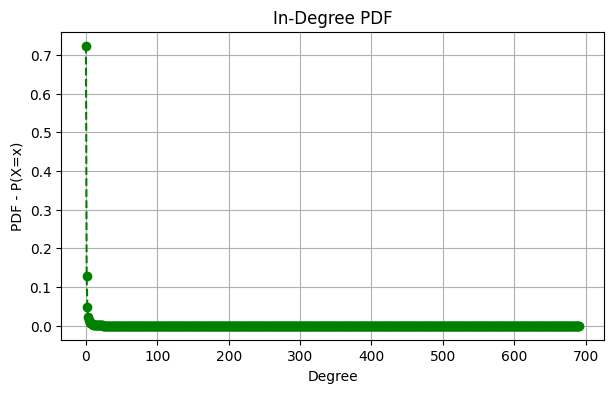

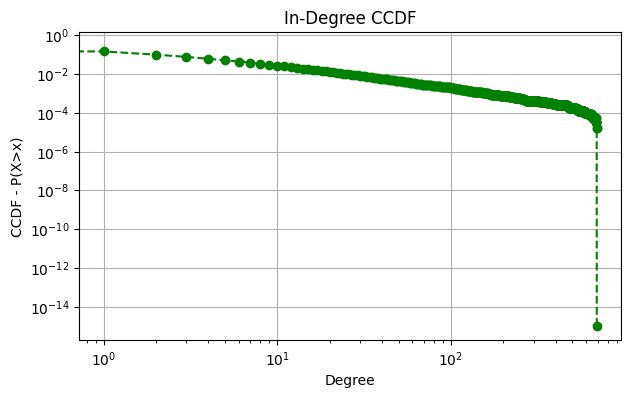

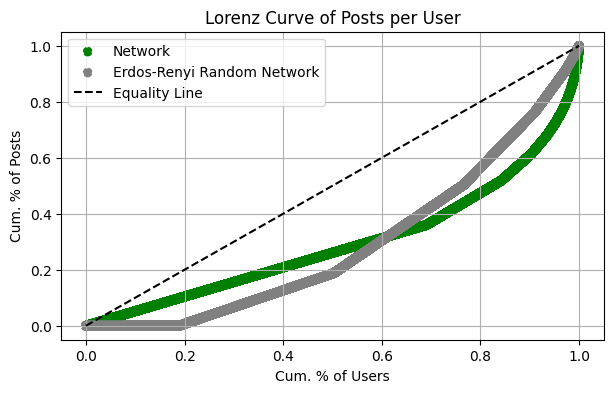

Gini Coefficient: 0.40516


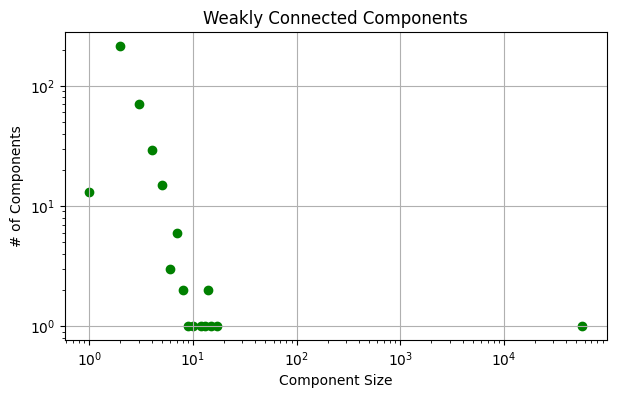

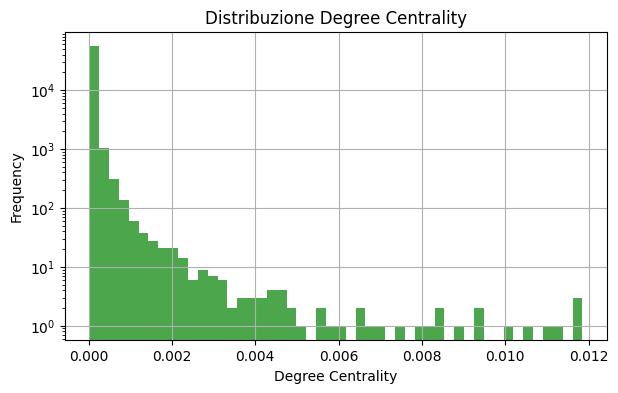

In [8]:
analyze_graph(Youtube_Graph, color="green")

In [ ]:
nx.write_gexf(Youtube_Graph, "youtube.gexf")